<a href="https://colab.research.google.com/github/laxmivaishnavee22/OasisInfobyte/blob/main/Predicting_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import f_regression, SelectKBest
import joblib
import os

In [ ]:
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=['MedHouseVal'])
y = data.frame['MedHouseVal']

print("Dataset loaded.")
print(f"Features shape: {X.shape}, Target shape: {y.shape}")
print("Feature names:", list(X.columns))

Dataset loaded.
Features shape: (20640, 8), Target shape: (20640,)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [ ]:
print("\n--- Quick EDA ---")
print("First 5 rows:")
print(data.frame.head())

print("\nSummary statistics for features:")
print(X.describe().T[['mean', 'std', 'min', 'max']])


--- Quick EDA ---
First 5 rows:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

Summary statistics for features:
                   mean          std         min           max
MedInc         3.870671     1.899822    0.499900     15.000100
HouseAge      28.639486    12.585558    1.000000     52.000000
AveRooms       5.429000     2.474173    0.846154    141.909091
AveBedrms      1.096675     0.473911    0.333333     34.

In [ ]:
print("\nMissing values per column:")
print(X.isna().sum())



Missing values per column:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64


In [ ]:
corrs = pd.concat([X, y], axis=1).corr()['MedHouseVal'].abs().sort_values(ascending=False)
print("\nAbsolute correlations with target (descending):")
print(corrs)


Absolute correlations with target (descending):
MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
Latitude       0.144160
HouseAge       0.105623
AveBedrms      0.046701
Longitude      0.045967
Population     0.024650
AveOccup       0.023737
Name: MedHouseVal, dtype: float64


In [ ]:
k = min(8, X.shape[1])
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)
mask = selector.get_support()
selected_features = X.columns[mask].tolist()
print(f"\nSelected top-{k} features (SelectKBest): {selected_features}")

X_sel = X[selected_features]


Selected top-8 features (SelectKBest): ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16512, 8), Test shape: (4128, 8)


In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
print("\nModel trained.")


Model trained.


In [ ]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [ ]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

train_metrics = regression_metrics(y_train, y_pred_train)
test_metrics = regression_metrics(y_test, y_pred_test)

print("\nTraining metrics:")
for k, v in train_metrics.items():
    print(f"  {k}: {v:.4f}")

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")


Training metrics:
  MSE: 0.5179
  RMSE: 0.7197
  MAE: 0.5286
  R2: 0.6126

Test metrics:
  MSE: 0.5559
  RMSE: 0.7456
  MAE: 0.5332
  R2: 0.5758


In [ ]:
coef_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': model.coef_
}).sort_values(by='coefficient', key=abs, ascending=False)

print("\nModel coefficients (by absolute size):")
print(coef_df)



Model coefficients (by absolute size):
      feature  coefficient
3   AveBedrms     0.783145
0      MedInc     0.448675
7   Longitude    -0.433708
6    Latitude    -0.419792
2    AveRooms    -0.123323
1    HouseAge     0.009724
5    AveOccup    -0.003526
4  Population    -0.000002



Saved predicted vs actual plot to: output/predicted_vs_actual.png


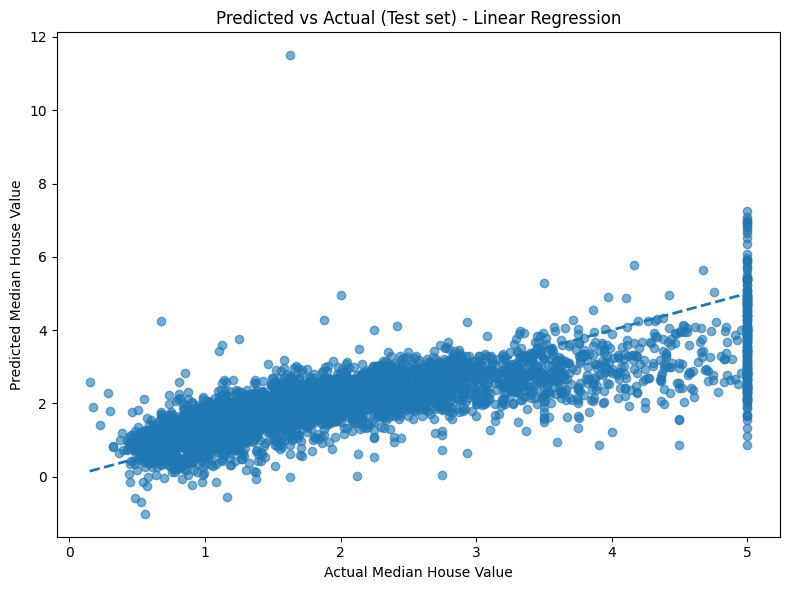

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', linewidth=2)
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.title('Predicted vs Actual (Test set) - Linear Regression')
plt.tight_layout()

os.makedirs("output", exist_ok=True)
plot_path = os.path.join("output", "predicted_vs_actual.png")
plt.savefig(plot_path, dpi=150)
print(f"\nSaved predicted vs actual plot to: {plot_path}")
plt.show()

Saved residuals histogram to: output/residuals_hist.png


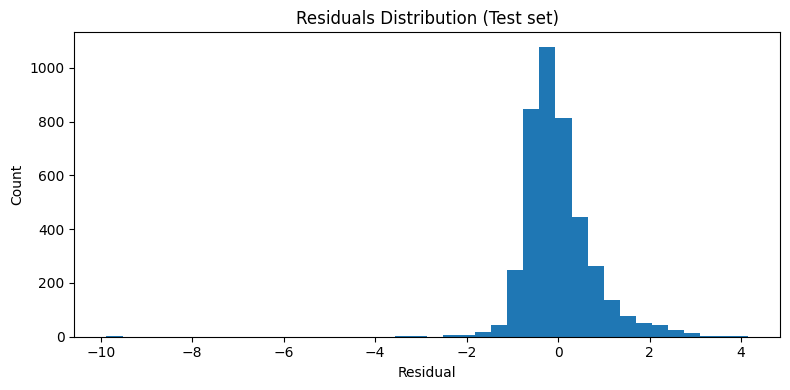

In [ ]:
plt.figure(figsize=(8, 4))
residuals = y_test - y_pred_test
plt.hist(residuals, bins=40)
plt.title("Residuals Distribution (Test set)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
resid_path = os.path.join("output", "residuals_hist.png")
plt.savefig(resid_path, dpi=150)
print(f"Saved residuals histogram to: {resid_path}")
plt.show()

In [ ]:
import os

model_path = os.path.join("output", "linear_regression_model.joblib")
joblib.dump({'model': model, 'features': selected_features}, model_path)
print(f"\nSaved trained model to: {model_path}")

sample = X_test.iloc[0:3]
sample_preds = model.predict(sample)
print("\nExample predictions for 3 test samples:")
print(pd.DataFrame({'predicted': sample_preds, 'actual': y_test.iloc[0:3].values}, index=sample.index))

print("\nCompleted.")


Saved trained model to: output/linear_regression_model.joblib

Example predictions for 3 test samples:
       predicted   actual
20046   0.719123  0.47700
3024    1.764017  0.45800
15663   2.709659  5.00001

Completed.
